# 使用已有的关联做推荐

一种思路是使用已有的关联做推荐,比如亚马逊推荐商品,网飞推荐电视剧,他们已经有一些用户对商品的行为数据,比如点击行为,收藏行为,购买行为.对这些行为加权处理为一个范围内的数值,就可以认为这是一个用户对一个物品的关联.

处理这种已有关联的数据我们有两种方式:

1. 协同过滤
2. 基于矩阵分解的算法

要使用已有的关联做推荐,首先我们可以建立一个行为物品,列为用户的关系矩阵,以下这个例子来自于集体智慧编程.是一个向用户推荐电影的例子.用户评分范围为1到5

In [1]:
import pandas as pd

In [2]:
critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 
 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 
 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0, 
 'You, Me and Dupree': 3.5}, 
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0, 
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0}, 
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

In [3]:
rela_matrix = pd.DataFrame(critics).T
rela_matrix

,Just My Luck,Lady in the Water,Snakes on a Plane,Superman Returns,The Night Listener,"You, Me and Dupree"
Lisa Rose,3.0,2.5,3.5,3.5,3.0,2.5
Gene Seymour,1.5,3.0,3.5,5.0,3.0,3.5
Michael Phillips,NaN,2.5,3.0,3.5,4.0,NaN
Claudia Puig,3.0,NaN,3.5,4.0,4.5,2.5
Mick LaSalle,2.0,3.0,4.0,3.0,3.0,2.0
Jack Matthews,NaN,3.0,4.0,5.0,3.0,3.5
Toby,NaN,NaN,4.5,4.0,NaN,1.0


这张表相当的"理论",真实情况是关系矩阵会比上面这个例子稀疏很多,全中国的人又多少?淘宝上的商品有多少?每个人又能接触多少的商品呢?不过暂且用这个例子来讲解使用已有的关联做推荐的方法也是够的.

## 协同过滤

协同过滤的基本假设有两个

1. 相似用户喜欢同一个商品(user-base)/相似商品会被同一个用户喜欢(item-base)
2. 用户的喜好不随时间变化
3. 用户不会改变,物品也不会改变



我们以user-base的协同过滤为例讲下大致原理

### 评估相似度

基本假设就是相似用户会喜欢同一个商品(user-base),因此我们需要先计算用户间的相似度.,如何计算相似呢?我们可以使用多种度量,常见的有

+ 欧式距离

$$ d = \sqrt{\sum\limits_{i=1}^n (x_i - y_i)^2} $$

+ 皮尔逊相关系数

+ cosine相似度

等,这边使用皮尔逊相关系数作为例子

In [4]:
sim_matrix = rela_matrix.T.corr()

In [5]:
sim_matrix

,Lisa Rose,Gene Seymour,Michael Phillips,Claudia Puig,Mick LaSalle,Jack Matthews,Toby
Lisa Rose,1.000000,0.396059,0.404520,0.566947,0.594089,0.747018,0.991241
Gene Seymour,0.396059,1.000000,0.204598,0.314970,0.411765,0.963796,0.381246
Michael Phillips,0.404520,0.204598,1.000000,1.000000,-0.258199,0.134840,-1.000000
Claudia Puig,0.566947,0.314970,1.000000,1.000000,0.566947,0.028571,0.893405
Mick LaSalle,0.594089,0.411765,-0.258199,0.566947,1.000000,0.211289,0.924473
Jack Matthews,0.747018,0.963796,0.134840,0.028571,0.211289,1.000000,0.662849
Toby,0.991241,0.381246,-1.000000,0.893405,0.924473,0.662849,1.000000


In [6]:
sim_matrix.to_dict()

{'Lisa Rose': {'Lisa Rose': 1.0,
  'Gene Seymour': 0.39605901719066977,
  'Michael Phillips': 0.40451991747794525,
  'Claudia Puig': 0.5669467095138409,
  'Mick LaSalle': 0.5940885257860046,
  'Jack Matthews': 0.747017880833996,
  'Toby': 0.9912407071619304},
 'Gene Seymour': {'Lisa Rose': 0.39605901719066977,
  'Gene Seymour': 1.0,
  'Michael Phillips': 0.20459830184114206,
  'Claudia Puig': 0.314970394174356,
  'Mick LaSalle': 0.4117647058823529,
  'Jack Matthews': 0.9637956818756329,
  'Toby': 0.3812464258315117},
 'Michael Phillips': {'Lisa Rose': 0.40451991747794525,
  'Gene Seymour': 0.20459830184114206,
  'Michael Phillips': 1.0,
  'Claudia Puig': 1.0,
  'Mick LaSalle': -0.2581988897471611,
  'Jack Matthews': 0.13483997249264842,
  'Toby': -1.0},
 'Claudia Puig': {'Lisa Rose': 0.5669467095138409,
  'Gene Seymour': 0.314970394174356,
  'Michael Phillips': 1.0,
  'Claudia Puig': 1.0,
  'Mick LaSalle': 0.5669467095138409,
  'Jack Matthews': 0.02857142857142857,
  'Toby': 0.89340514

这样我们就有了用户之间的相似度矩阵,我们可以看到比如Lisa Rose和Jack Matthews品味相近,这样的信息

### 计算推荐

在有了这张相似度表后,当我们要为某一个人推荐时,只要找到其他人和他的相关度,以其做为权重,为每个物品计算加权后的评分和即可.我们注意到有空值在rela_matrix中,这样就无法计算了,因此我们把空值替换为0.之后求出出自己外的每个电影在每个人那边的加权分,然后将结果初一权重的和来归一化.

In [7]:
def recommend_cf_list(name):
    weights = sim_matrix.to_dict()[name]
    del weights[name]
    rela_score = rela_matrix.fillna(0).drop(index=[name]).to_dict()
    result = {}
    for key,tab in rela_score.items():
        temp = 0
        for i,value in tab.items():
            temp += value*weights[i]
        result[key]=temp
    return {key:i/sum(weights.values()) for key,i in result.items()}

In [8]:
recommend_cf_list("Lisa Rose")

{'Just My Luck': 0.9414122954368538,
 'Lady in the Water': 1.6818946142760218,
 'Snakes on a Plane': 3.8944822017436005,
 'Superman Returns': 4.093713604813386,
 'The Night Listener': 2.535448310746034,
 'You, Me and Dupree': 2.05346350337327}

剩下的也就是给这些物品按得分排个序了

In [9]:
sorted(recommend_cf_list("Lisa Rose").items(),key=lambda x:x[-1],reverse=True)

[('Superman Returns', 4.093713604813386),
 ('Snakes on a Plane', 3.8944822017436005),
 ('The Night Listener', 2.535448310746034),
 ('You, Me and Dupree', 2.05346350337327),
 ('Lady in the Water', 1.6818946142760218),
 ('Just My Luck', 0.9414122954368538)]

基于物品的也是一样,支持角色反过来而已.如果我们的业务是用户买了一样商品,我们要向他推荐另一样商品,而且尤其当我们对这个用户并没有收集到足够信息时那么我们就可以使用基于物品的协同过滤.计算物品间的相似程度,然后推荐相似的物品给.

In [10]:
rela_matrix_item = rela_matrix.T
rela_matrix_item

,Lisa Rose,Gene Seymour,Michael Phillips,Claudia Puig,Mick LaSalle,Jack Matthews,Toby
Just My Luck,3.0,1.5,NaN,3.0,2.0,NaN,NaN
Lady in the Water,2.5,3.0,2.5,NaN,3.0,3.0,NaN
Snakes on a Plane,3.5,3.5,3.0,3.5,4.0,4.0,4.5
Superman Returns,3.5,5.0,3.5,4.0,3.0,5.0,4.0
The Night Listener,3.0,3.0,4.0,4.5,3.0,3.0,NaN
"You, Me and Dupree",2.5,3.5,NaN,2.5,2.0,3.5,1.0


In [11]:
sim_matrix_item = rela_matrix_item.T.corr()
sim_matrix_item

,Just My Luck,Lady in the Water,Snakes on a Plane,Superman Returns,The Night Listener,"You, Me and Dupree"
Just My Luck,1.000000,-0.944911,-0.333333,-0.422890,0.555556,-0.485662
Lady in the Water,-0.944911,1.000000,0.763763,0.487950,-0.612372,0.333333
Snakes on a Plane,-0.333333,0.763763,1.000000,0.111803,-0.566352,-0.645497
Superman Returns,-0.422890,0.487950,0.111803,1.000000,-0.179847,0.657952
The Night Listener,0.555556,-0.612372,-0.566352,-0.179847,1.000000,-0.250000
"You, Me and Dupree",-0.485662,0.333333,-0.645497,0.657952,-0.250000,1.000000


In [12]:
def recommend_cf_item(item):
    result = sim_matrix_item.drop(index=[item])[item]
    return result.sort_values(ascending=False)

In [13]:
recommend_cf_item("Just My Luck")

The Night Listener    0.555556
Snakes on a Plane    -0.333333
Superman Returns     -0.422890
You, Me and Dupree   -0.485662
Lady in the Water    -0.944911
Name: Just My Luck, dtype: float64

甚至我们还可以主动选择推送一个新产品给什么人

In [14]:
def recommend_cf_item_to_people(name):
    weights = sim_matrix_item.to_dict()[name]
    del weights[name]
    rela_score = rela_matrix_item.fillna(0).drop(index=[name]).to_dict()
    result = {}
    for key,tab in rela_score.items():
        temp = 0
        for i,value in tab.items():
            temp += value*weights[i]
        result[key]=temp
    return sorted({key:i/sum(weights.values()) for key,i in result.items()}.items(),key=lambda x:x[-1],reverse=True)

In [15]:
recommend_cf_item_to_people("Snakes on a Plane")

[('Claudia Puig', 7.0415123776298385),
 ('Lisa Rose', 3.0048251432487247),
 ('Gene Seymour', 2.4013616874633836),
 ('Jack Matthews', 1.6546658058621195),
 ('Mick LaSalle', 1.5382225075580365),
 ('Toby', 0.29611513812929585),
 ('Michael Phillips', -0.052731633004085426)]

### 协同过滤的优缺点

协同过滤是最基本的推荐算法,它的优点
+ 大部分计算可以离线运算
+ 可解释性很好

但缺点也很明显:
+ 对比较新的数据难以处理(稀疏性问题)
+ 必须要有用户-物品关系数据(冷启动问题)
+ 计算量巨大

针对这些问题还有一些改进算法,比如计算相似度可以通过标签等外部信息做聚类,然后将聚类的结果作为用户群进行推荐,当某用户属于这个用户群,这样问题就成了向某个群体推荐商品,这样可以大大降低计算量



## 基于矩阵分解的算法

这一类算法往往利用到矩阵分解,它基于这么一个假设,用户喜欢某个东西不是喜欢它本身,而是喜欢其一些特征,比如喜欢集体智慧编程的可能也会喜欢数学之美,因为他们都是介绍算法的书.当然在关系矩阵中我们没办法或得到不同物品的特征,所以我们就假设有这么一些特征我们也不知道是什么,它就是决定用户偏好的因子.这种算法统称为隐因子模型(LFM)

$$ R_{M,N}=P_{M,F}⋅Q_{F,N} $$

其中$F$代表隐因子的数量(超参);$R_{M,N}$为我们的特征矩阵,这个矩阵通常是一个非常稀疏的矩阵.$P_{M,F}$为用户对各隐因子的喜好程度矩阵,Q_{F,N}则代表隐因子在物品上的概率分布.

而我们训练的目标是使得对所有的$r_{m,n}≠0$,且$r_{m,n}$和$\hat{r}_{m,n}$尽可能接近，即

$$ min: Loss ==\sum\limits_{r_{m,n}\neq0}(r_{m,n} -\hat{r}_{m,n})^2$$

为防止过拟合,加个正则项,以防止$P_{m,f}$,$Q_{f,n}$过大或过小,即:

$$ min: Loss ==\sum\limits_{r_{m,n}\neq0}(r_{m,n} -\hat{r}_{m,n})^2 + \lambda(\sum P_{m,f}^2+\sum Q_{f,n})$$

这样我们就可以用梯度下降法来训练模型了.

我们使用的是keras2来构造模型.使用movielens的数据集以模拟真实情况下数据稀疏的情况.

In [16]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, Reshape
from keras.layers.merge import Dot, Concatenate
from keras.models import Model, Input

Using TensorFlow backend.


In [19]:
ratings = pd.read_csv('./data/ratings.dat', sep = '::', engine='python',names = ['user_id','movie_id','rating','timestamp'])

In [21]:
ratings[:10]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


我们的数据集是一个用户id和电影id构成的关系表,rating是评分.,首先我们来观察下数据

In [24]:
M = np.max(ratings['user_id'])
M

6040

In [25]:
N = np.max(ratings['movie_id'])
N

3952

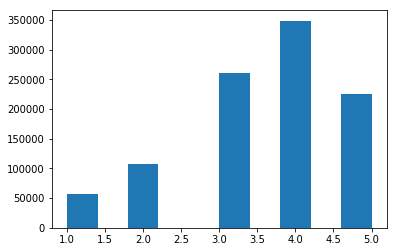

In [26]:
plt.hist(ratings['rating'])
plt.show()

In [27]:
print(np.mean(ratings['rating']))

3.581564453029317


In [30]:
k = 128 # 隐因子数
# 用户嵌入
model1 = Sequential()
model1.add(Embedding(M + 1, k, input_length = 1))
model1.add(Reshape((k,)))

# 物品嵌入
model2 = Sequential()
model2.add(Embedding(N + 1, k, input_length = 1))
model2.add(Reshape((k,)))

Instructions for updating:
Colocations handled automatically by placer.


我们的思路是通过计算用户和内容的向量乘积得出评分.

In [31]:
#model = Sequential()
m = Dot(axes=1)([model1.output, model2.output])
model_output = m
model = Model([model1.input, model2.input], model_output)
model.compile(loss = 'mse', optimizer = 'adam')

准备好训练数据

In [32]:
users = ratings['user_id'].values
movies = ratings['movie_id'].values
X_train = [users, movies]
y_train = ratings['rating'].values

In [33]:
model.fit(X_train, y_train, batch_size = 500, epochs = 50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1000209/1000209 [==============================] - 44s 44us/step - loss: 4.2632
Epoch 2/50
1000209/1000209 [==============================] - 44s 44us/step - loss: 0.8199
Epoch 3/50
1000209/1000209 [==============================] - 44s 44us/step - loss: 0.7405
Epoch 4/50
1000209/1000209 [==============================] - 41s 41us/step - loss: 0.6754
Epoch 5/50
1000209/1000209 [==============================] - 41s 41us/step - loss: 0.6114
Epoch 6/50
1000209/1000209 [==============================] - 41s 41us/step - loss: 0.5421
Epoch 7/50
1000209/1000209 [==============================] - 45s 45us/step - loss: 0.4710
Epoch 8/50
1000209/1000209 [==============================] - 42s 42us/step - loss: 0.4051
Epoch 9/50
1000209/1000209 [==============================] - 43s 43us/step - loss: 0.3495
Epoch 10/50
1000209/1000209 [==============================] - 38s 38us/step - loss: 0.3053
Epoch 11/50
1000209/1000209 [============

我们看下模型预测效果,注意我们这里作为演示,只做了模型拟合程度,读者可以把原始数据集分成训练,验证和测试数据集,评估模型准确率和泛化能力.我们这里看一个例子--预测第10号用户对第99号内容的打分.

In [34]:
i=10
j=99
pred = model.predict([np.array([users[i]]), np.array([movies[j]])])
pred

array([[2.965229]], dtype=float32)

### 深度模型

在一般矩阵分解模型的基础上,我们可以结合深度神经网络替代简单的矩阵乘法,以此来挖掘更深层次的关联信息.在代码上我们只需要修改Dot为连接,然后构造多层神经网络

In [36]:
k = 128
# 输入
input_1 = Input(shape=(1,))
model1 = Embedding(M + 1, k, input_length = 1)(input_1)
model1 = Reshape((k,))(model1)
input_2 = Input(shape=(1,))
model2 = Embedding(N + 1, k, input_length = 1)(input_2)
model2 = Reshape((k,))(model2)

In [37]:
# 模型融合
model = Concatenate()([model1, model2])
# 神经网络构造
model = Dropout(0.2)(model)
model = Dense(k, activation = 'relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/4), activation = 'relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/16), activation = 'relu')(model)
model = Dropout(0.5)(model)
# 输出
yhat = Dense(1, activation = 'linear')(model)
model = Model([input_1, input_2], yhat)
model.compile(loss = 'mse', optimizer = "adam")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
model.fit(X_train, y_train, batch_size = 1000, epochs = 50)

Epoch 1/50
1000209/1000209 [==============================] - 37s 37us/step - loss: 3.2110
Epoch 2/50
1000209/1000209 [==============================] - 36s 36us/step - loss: 1.9703
Epoch 3/50
1000209/1000209 [==============================] - 36s 36us/step - loss: 1.4733
Epoch 4/50
1000209/1000209 [==============================] - 37s 37us/step - loss: 1.1621
Epoch 5/50
1000209/1000209 [==============================] - 36s 36us/step - loss: 0.9970
Epoch 6/50
1000209/1000209 [==============================] - 37s 37us/step - loss: 0.9420
Epoch 7/50
1000209/1000209 [==============================] - 36s 36us/step - loss: 0.9269
Epoch 8/50
1000209/1000209 [==============================] - 36s 36us/step - loss: 0.9174
Epoch 9/50
1000209/1000209 [==============================] - 37s 37us/step - loss: 0.9099
Epoch 10/50
1000209/1000209 [==============================] - 38s 38us/step - loss: 0.8968
Epoch 11/50
1000209/1000209 [==============================] - 39s 39us/step - loss: 0.89

In [39]:
i=10
j=99
pred = model.predict([np.array([users[i]]), np.array([movies[j]])])
pred

array([[3.392807]], dtype=float32)

### 基于矩阵分解的算法优势和局限性

矩阵分解的算法相比协同过滤更加复杂,但它带来了一个优势--可以更好的处理稀疏矩阵.然而这依然脱离不了用已有的关联做推荐固有的局限性--无法利用外部信息.

要利用外部的特征,从深度模型改造,可以使用深宽模型,这个会在最后一节介绍